## 0.Import libraries

In [38]:
import pandas as pd
import os, sys
import numpy as np
from dataclasses import dataclass
import random, math, operator
from pprint import pprint
import pickle, gc, itertools
from pathlib import Path
import time, datetime
from collections import *
import matplotlib.pyplot as plt
import subprocess
from collections import deque

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from keras.layers import LSTM

import warnings

## 1.Setup configuration

In [39]:
from requests import get
#colab_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
colab_filename = 'FxBERT_downstream_readFromRawData_baselineLSTM.ipynb'
result_filename = colab_filename.replace('.ipynb', '.csv')
result_filename

'FxBERT_downstream_readFromRawData_baselineLSTM.csv'

In [40]:
@dataclass
class Config:
    BATCH_SIZE = 1024
    EMBED_DIM = 128
    NUM_HEAD = 8  # used in bert model
    FF_DIM = 1024  # used in bert model
    NUM_LAYERS = 12
    EPOCH = 3 # 10000
    SEQLENGTH = 100
    CURRENCY ='USD_JPY_M15'
    MASK_PERCT = 0.15
    maxlen = 100
    patience = 30
    seqlen = 10
    isTrain = True

config = Config()

In [41]:
from google.colab import drive
drive.mount('/content/drive')
base_folder = '/content/drive/MyDriveTradingBERT/'


gd_rawdata_folder = base_folder + '1.rawData/'
gd_ref_folder = base_folder + '2.refData/'
gd_processedData_folder = base_folder + '3.processedData/'
gd_mdl_folder = base_folder + '4.model/downstream/'+config.CURRENCY+'/'
gd_mdl_upstream_folder = base_folder + '4.model/upstream/'
gd_result_folder = base_folder + '5.result/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
Path(gd_processedData_folder).mkdir(parents=True, exist_ok=True)
Path(gd_ref_folder).mkdir(parents=True, exist_ok=True)
Path(gd_mdl_folder).mkdir(parents=True, exist_ok=True)
Path(gd_result_folder).mkdir(parents=True, exist_ok=True)
# Path(gd_rawdata_folder).mkdir(parents=True, exist_ok=True)

## 2.Preparation

### 2.1 Data preprocessing

In [43]:
def unpickleData(file):
    print("start processing data ...")
    data_dict = {}

    if not os.path.isfile(file):
        print(file, "does not exist.")
    else:
        print(file, "... unpacking ...")
        with open(file, "rb") as fp:
            unpickler = pickle.Unpickler(fp)
            try:
                data_dict.update(unpickler.load())
            except:
                pass
            fp.close()

    print("len(data_dict)", len(data_dict))
    return data_dict

refData = unpickleData(os.path.join(gd_ref_folder, config.CURRENCY+'_dictionary_github.txt'))

start processing data ...
/content/drive/MyDrive/MyResearch_FT/14.BERT/11.github/TradingBERT/2.refData/USD_JPY_M15_dictionary_github.txt ... unpacking ...
len(data_dict) 8


In [44]:
candlestick_vocab_size=len(refData['candlestick_encode_dict'])  # 39083
pos_vocab_size=len(refData['pos_decode_dict'])  # 6109
direction_vocab_size=len(refData['direction_encode_dict'])   # 7
candlepiece_vocab_size=len(refData['candlepiece_encode_dict'])   # 138
segment_size=3

In [45]:
df_raw = pd.read_csv(os.path.join(gd_rawdata_folder, config.CURRENCY+'_200501_202206.csv'))
df_raw['datetime'] = pd.to_datetime(df_raw['datetime'], format='%Y-%m-%dT%H:%M:%S.000000000Z')

if config.CURRENCY == 'USD_JPY_M15':
    pip = 0.01
elif config.CURRENCY == 'AUD_USD_M15':
    pip = 0.0001
elif config.CURRENCY == 'EUR_GBP_M15':
    pip = 0.0001
else:
    print('please check')

df_raw['pip'] = pip
df_raw['avg'] = df_raw[['open', 'high', 'low', 'close']].mean(axis=1)

In [46]:
def getHandL_next_N_window(df, windowSize, pips):
    def idx_max(x):
        return x.index.values[np.argmax(x.values)]
    def idx_min(x):
        return x.index.values[np.argmin(x.values)]
    df_max_next = df['high'].rolling(windowSize).agg(['max', idx_max]).shift(-1*windowSize)
    df_min_next = df['low'].rolling(windowSize).agg(['min', idx_min]).shift(-1*windowSize)
    df_merged = pd.concat([df, df_max_next, df_min_next], axis=1)
    df_merged = df_merged.rename(columns={'max': 'hh_next_'+str(windowSize), \
                                          'idx_max': 'hh_next_idx_'+str(windowSize), \
                                          'min': 'll_next_'+str(windowSize), \
                                          'idx_min': 'll_next_idx_'+str(windowSize)})

    df_merged['hh_diff_'+str(windowSize)]=df_merged.apply(lambda row: (row['hh_next_'+str(windowSize)]-row['close'])/pips, axis=1)
    df_merged['ll_diff_'+str(windowSize)]=df_merged.apply(lambda row: (row['close']-row['ll_next_'+str(windowSize)])/pips, axis=1)

    return df_merged

In [47]:
def get_labels_buy_hold_sell(df, windowSize, pips, pt, sl):
    if ('hh_diff_'+str(windowSize) not in list(df.columns)) or ('ll_diff_'+str(windowSize) not in list(df.columns)):
        df = getHandL_next_N_window(df, windowSize, pips)

    conditions = [
        (df['hh_diff_'+str(windowSize)]>pt) & (df['ll_diff_'+str(windowSize)]<sl),
        (df['hh_diff_'+str(windowSize)]>pt) & (df['ll_diff_'+str(windowSize)]>sl)
                & (df['hh_next_idx_'+str(windowSize)]<df['ll_next_idx_'+str(windowSize)]),
        (df['ll_diff_'+str(windowSize)]>pt) & (df['hh_diff_'+str(windowSize)]<sl),
        (df['ll_diff_'+str(windowSize)]>pt) & (df['hh_diff_'+str(windowSize)]>sl)
                & (df['ll_next_idx_'+str(windowSize)]<df['hh_next_idx_'+str(windowSize)]),
    ]
    label_dict = {0:'buy', 1:'sell', 2:'hold'}

    #labels = ['buy','buy','sell','sell']
    labels = [0, 0, 1, 1]
    df['label_bhs_ws'+str(windowSize)+'_pt'+str(pt)+'_sl'+str(sl)] = np.select(conditions, labels, default=2) # hold
    df.drop(columns=['hh_next_idx_'+str(windowSize), 'll_next_idx_'+str(windowSize), 'hh_diff_'+str(windowSize), 'll_diff_'+str(windowSize)], inplace=True)

    return df

In [48]:
%%capture
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

import talib

In [49]:
def getTalibIndicators(df):
    high = df.high
    low = df.low
    open = df.open
    close = df.close

    df['macd'], df['macd_signal'], df['macd_hist'] = talib.MACD(df['close'], 12, 26, 9)

    for i in range(10, 50, 10):
        df['RSI_'+str(i)] = talib.RSI(close, timeperiod=i)
        df['WILLR_'+str(i)] = talib.WILLR(high, low, close, timeperiod=i)
        df['EMA_'+str(i)] = talib.EMA(close, timeperiod=i)

    return df

In [50]:
def getCandleElements(df_tmp, direction_encode_dict, candlepiece_encode_dict, pos_encode_dict, candlestick_encode_dict):

    df_tmp['direction'] = 0
    df_tmp.loc[df_tmp['close'] > df_tmp['open'], 'direction'] = 1
    df_tmp.loc[df_tmp['close'] < df_tmp['open'], 'direction'] = -1

    df_tmp['candle_len'] = abs(df_tmp['close']-df_tmp['open'])/df_tmp['pip']
    df_tmp['candle_len'] = df_tmp['candle_len'].apply(lambda r: round(r, 0)).astype(int)

    df_tmp['upper_len'] = 0
    df_tmp.loc[df_tmp['close'] > df_tmp['open'], 'upper_len'] = abs(df_tmp['high']-df_tmp['close'])/df_tmp['pip']
    df_tmp.loc[df_tmp['close'] < df_tmp['open'], 'upper_len'] = abs(df_tmp['high']-df_tmp['open'])/df_tmp['pip']
    df_tmp['upper_len'] = df_tmp['upper_len'].apply(lambda r: round(r, 0)).astype(int)

    df_tmp['lower_len'] = 0
    df_tmp.loc[df_tmp['close'] > df_tmp['open'], 'lower_len'] = abs(df_tmp['low']-df_tmp['open'])/df_tmp['pip']
    df_tmp.loc[df_tmp['close'] < df_tmp['open'], 'lower_len'] = abs(df_tmp['low']-df_tmp['close'])/df_tmp['pip']
    df_tmp['lower_len'] = df_tmp['lower_len'].apply(lambda r: round(r, 0)).astype(int)

    df_tmp['pos_low'] = df_tmp['low']/df_tmp['pip']
    df_tmp['pos_low'] = df_tmp['pos_low'].apply(lambda r: round(r, 0)).astype(int)

    df_tmp['direction_encoded'] = df_tmp['direction'].apply(lambda row: direction_encode_dict[int(row)])
    df_tmp['candle_len_encoded'] = df_tmp['candle_len'].apply(lambda row: candlepiece_encode_dict[int(row)])
    df_tmp['upper_len_encoded'] = df_tmp['upper_len'].apply(lambda row: candlepiece_encode_dict[int(row)])
    df_tmp['lower_len_encoded'] = df_tmp['lower_len'].apply(lambda row: candlepiece_encode_dict[int(row)])
    df_tmp['pos_low_encoded'] = df_tmp['pos_low'].apply(lambda row: pos_encode_dict[int(row)])

    def getCandlestickEncoded(row):
        key = str([int(i) for i in row[['candle_len', 'upper_len', 'lower_len', 'direction']].values.tolist()])
        if key in candlestick_encode_dict.keys():
            return candlestick_encode_dict[key]
        else:
            return 0

    df_tmp['candlestick_encoded'] = df_tmp.apply(lambda row: getCandlestickEncoded(row), axis=1)

    return df_tmp

In [51]:
def data_preprocessing(df,direction_encode_dict, candlepiece_encode_dict, pos_encode_dict, candlestick_encode_dict):
    df = getCandleElements(df, direction_encode_dict, candlepiece_encode_dict, pos_encode_dict, candlestick_encode_dict)
    df = getTalibIndicators(df)
    df = get_labels_buy_hold_sell(df, windowSize=10, pips=pip, pt=10, sl=8)  # 'label_bhs_ws10_pt10_sl8'
    return df

pos_encode_dict = refData['pos_encode_dict']
candlepiece_encode_dict = refData['candlepiece_encode_dict']
direction_encode_dict = refData['direction_encode_dict']
candlestick_encode_dict = refData['candlestick_encode_dict']

df_downstream = data_preprocessing(df_raw, direction_encode_dict, candlepiece_encode_dict, pos_encode_dict, candlestick_encode_dict)
df_downstream = df_downstream.tail(len(df_downstream)-50)
df_downstream = df_downstream.head(len(df_downstream)-10)
df_downstream.reset_index(drop=True, inplace=True)
assert df_downstream.isnull().sum().sum() == 0

In [52]:
df_downstream_train = df_downstream[(df_downstream['datetime']>='2020-01-01') & (df_downstream['datetime']<'2022-01-01')]
df_downstream_train.reset_index(drop=True, inplace=True)
df_downstream_valid = df_downstream[(df_downstream['datetime']>='2022-01-01') & (df_downstream['datetime']<'2022-04-01')]
df_downstream_valid.reset_index(drop=True, inplace=True)
df_downstream_test = df_downstream[(df_downstream['datetime']>='2022-04-01') & (df_downstream['datetime']<'2022-07-01')]
df_downstream_test.reset_index(drop=True, inplace=True)

print(len(df_downstream_train), len(df_downstream_valid), len(df_downstream_test))

49894 6156 6212


In [53]:
ta_columns = ['macd','macd_signal','macd_hist','RSI_10','WILLR_10','EMA_10','RSI_20','WILLR_20',
                'EMA_20','RSI_30','WILLR_30','EMA_30','RSI_40','WILLR_40','EMA_40']
pad_token_id = 0
masked_token_id = 1
startSent_token_id = 2
sepSent_token_id = 3

def generateSeq4Downstream(df_ds, ds_type, input_type, seqlen, maxlen=config.maxlen):
    batch = []
    for i in range(len(df_ds)-seqlen):
        df_tmp = df_ds.loc[i:i+seqlen-1]
        assert len(df_tmp)==seqlen

        scaler = MinMaxScaler()

        candlestick_encoded = df_tmp[['candlestick_encoded', 'pos_low_encoded', 'direction_encoded',
                                    'candle_len_encoded', 'upper_len_encoded', 'lower_len_encoded']].values.tolist()
        input_ids = [[startSent_token_id]*6] + candlestick_encoded + [[sepSent_token_id]*6]
        segment_ids_3num = [1] * len(input_ids)

        n_pad = maxlen - len(input_ids)
        input_ids.extend([[pad_token_id]*6] * n_pad)
        segment_ids_3num.extend([pad_token_id] * n_pad)

        prices5_min = min(df_tmp[['open', 'high', 'low', 'close', 'avg']].min())
        prices5_max = max(df_tmp[['open', 'high', 'low', 'close', 'avg']].max())
        dt_tmp = [
                input_ids,
                segment_ids_3num,

                df_tmp[['open', 'high', 'low', 'close', 'avg']].values.tolist(),
                scaler.fit_transform(df_tmp[['open', 'high', 'low', 'close', 'avg']]),

                df_tmp[ta_columns].values.tolist(),
                scaler.fit_transform(df_tmp[ta_columns]),

                prices5_min,
                prices5_max,

                df_tmp.tail(1)[['hh_next_10']].values[0][0],
                (df_tmp.tail(1)[['hh_next_10']].values[0][0]-prices5_min)/(prices5_max-prices5_min),
                df_tmp.tail(1)[['ll_next_10']].values[0][0],
                (df_tmp.tail(1)[['ll_next_10']].values[0][0]-prices5_min)/(prices5_max-prices5_min),

                df_tmp.tail(1)[['label_bhs_ws10_pt10_sl8']].values[0][0]
            ]
        batch.append(dt_tmp)

    # return batch
    batch_transpose = [list(x) for x in list(zip(*batch))]
    input_ids = np.array(batch_transpose[0]).astype('int64')
    segment_ids_3num = np.array(batch_transpose[1]).astype('int64')
    prices5_ori = np.array(batch_transpose[2]).astype('float32')
    prices5_scaled = np.array(batch_transpose[3]).astype('float32')
    ta_ori = np.array(batch_transpose[4]).astype('float32')
    ta_scaled = np.array(batch_transpose[5]).astype('float32')
    prices5_min = np.array(batch_transpose[6]).astype('float32')
    prices5_max = np.array(batch_transpose[7]).astype('float32')
    hh_10_ori = np.array(batch_transpose[8]).astype('float32')
    hh_10_scaled = np.array(batch_transpose[9]).astype('float32')
    ll_10_ori = np.array(batch_transpose[10]).astype('float32')
    ll_10_scaled = np.array(batch_transpose[11]).astype('float32')
    label_bhs_ws10_pt10_sl8 = np.array(batch_transpose[12]).astype('int64')

    x_input_ids_candle, x_input_ids_pos, x_input_ids_die, x_input_ids_cle, x_input_ids_ule, x_input_ids_lle = \
                        split_arrays = [input_ids[:, :, i] for i in range(input_ids.shape[2])]
    x_input_ids_candle, x_input_ids_pos, x_input_ids_die, x_input_ids_cle, x_input_ids_ule, x_input_ids_lle = \
                        split_arrays[0], split_arrays[1], split_arrays[2], split_arrays[3], split_arrays[4], split_arrays[5]

    inputs = {}
    inputs['input_ids_candle'] = x_input_ids_candle
    inputs['input_ids_pos'] = x_input_ids_pos
    inputs['input_ids_die'] = x_input_ids_die
    inputs['input_ids_cle'] = x_input_ids_cle
    inputs['input_ids_ule'] = x_input_ids_ule
    inputs['input_ids_lle'] = x_input_ids_lle
    inputs['segment_ids'] = segment_ids_3num

    if input_type == 'incl_price5':
        inputs['prices5_scaled'] = prices5_scaled
    elif input_type == 'incl_ta':
        inputs['ta_scaled'] = ta_scaled
    elif input_type == 'incl_price5_ta':
        inputs['prices5_scaled'] = prices5_scaled
        inputs['ta_scaled'] = ta_scaled
    elif input_type == 'price5_ta':
        inputs = {}
        inputs['prices5_scaled'] = prices5_scaled
        inputs['ta_scaled'] = ta_scaled
    elif input_type == 'price5only':
        inputs = {}
        inputs['prices5_scaled'] = prices5_scaled
    elif input_type == 'taonly':
        inputs = {}
        inputs['ta_scaled'] = ta_scaled
    else:
        pass

    y_hh = hh_10_scaled
    y_ll = ll_10_scaled
    y_bhs = label_bhs_ws10_pt10_sl8

    targets = {}
    targets['max_price'] = y_hh
    targets['min_price'] = y_ll
    targets['label_bhs'] = y_bhs

    ref_data = {}
    ref_data['max_scale'] = prices5_max
    ref_data['min_scale'] = prices5_min
    ref_data['max_ori'] = hh_10_ori
    ref_data['min_ori'] = ll_10_ori

    if ds_type == 'test':
        return inputs, targets, ref_data
    else:
        return inputs, targets

### 2.2 Get position encoding

In [54]:
def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

## 3.Evaluation functions

### 3.1 Prediction

In [55]:
def get_predictions_all(mdl, test_dataset):
    y_pred_maxprice, y_pred_minprice, y_pred_labelbhs = [], [], []
    y_true_maxprice, y_true_minprice, y_true_labelbhs = [], [], []
    ref_max_scale, ref_min_scale, maxprice_ori, minprice_ori = [], [], [], []

    df_prediction = pd.DataFrame(columns=['y_true_labelbhs', 'y_pred_labelbhs', 'y_true_maxprice', 'y_pred_maxprice', 'maxprice_ori', \
                                          'y_true_minprice', 'y_pred_minprice', 'minprice_ori', 'ref_max_scale', 'ref_min_scale'])

    test_inputs = test_dataset[0]
    test_targets = test_dataset[1]
    ref_data = test_dataset[2]

    prediction_maxprice = [item for sublist in mdl.predict(test_inputs)[0].tolist() for item in sublist]
    prediction_minprice = [item for sublist in mdl.predict(test_inputs)[1].tolist() for item in sublist]
    prediction_labelbhs = mdl.predict(test_inputs)[2].argmax(axis=-1).tolist()

    y_pred_maxprice.extend(prediction_maxprice)
    y_true_maxprice.extend(test_targets['max_price'])

    y_pred_minprice.extend(prediction_minprice)
    y_true_minprice.extend(test_targets['min_price'])

    y_pred_labelbhs.extend(prediction_labelbhs)
    y_true_labelbhs.extend(test_targets['label_bhs'])

    ref_max_scale.extend(ref_data['max_scale'])
    ref_min_scale.extend(ref_data['min_scale'])
    maxprice_ori.extend(ref_data['max_ori'])
    minprice_ori.extend(ref_data['min_ori'])

    df_prediction['y_true_labelbhs'],  df_prediction['y_pred_labelbhs'] = y_true_labelbhs, y_pred_labelbhs
    df_prediction['y_true_maxprice'], df_prediction['y_pred_maxprice'], df_prediction['maxprice_ori'] = y_true_maxprice, y_pred_maxprice, maxprice_ori
    df_prediction['y_true_minprice'], df_prediction['y_pred_minprice'], df_prediction['minprice_ori'] = y_true_minprice, y_pred_minprice, minprice_ori
    df_prediction['ref_max_scale'], df_prediction['ref_min_scale'] = ref_max_scale, ref_min_scale

    df_prediction['maxprice_prediction'] = df_prediction.apply(lambda r: (r['ref_max_scale']-r['ref_min_scale'])*r['y_pred_maxprice']+r['ref_min_scale'], axis=1)
    df_prediction['minprice_prediction'] = df_prediction.apply(lambda r: (r['ref_max_scale']-r['ref_min_scale'])*r['y_pred_minprice']+r['ref_min_scale'], axis=1)

    return df_prediction

### 3.2 Evaluation function for regression model

In [56]:
def evaluate_regression_prediction(y_pred, y_true, model_name, printFlag=True):

    errors = np.array(y_pred) - np.array(y_true)
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.abs(100*errors/y_true).mean()

    if printFlag:
        print(model_name + ':')
        print('Mean Absolute Error: {:.8f}'.format(mae))
        print('Mean Absolute Percentage Error: {:.8f}'.format(mape))
        print('Mean Square Error: {:.8f}'.format(mse))
        print('Root Mean Square Error: {:.8f}'.format(rmse))
        print('')

    return mae, mape, mse, rmse

### 3.3 Evaluation function for classification model

In [57]:
def plot_confusion_matrix(cm, classes, title, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    plt.rcParams["figure.figsize"] = (10, 10)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # plt.savefig(gd_result_folder+'confusionMatrix/'+title+'.png', bbox_inches = "tight")
    plt.show()

In [58]:
#dict_classes = {'buy': 0, 'sell': 1, 'hold': 2}
#tuple(list(dict_classes.keys()))

In [59]:
def evaluate_classification_prediction(y_pred, y_true, dict_classes, title):

    precision, recall, fscore, support = score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    weighted_accuracy = balanced_accuracy_score(y_true, y_pred)

    pred_label = [list(dict_classes.keys())[list(dict_classes.values()).index(l)] for l in y_pred]
    actual_label = [list(dict_classes.keys())[list(dict_classes.values()).index(l)] for l in y_true]
    print(classification_report(actual_label, pred_label, digits=4))
    #print(confusion_matrix(actual_label, pred_label))
    plot_confusion_matrix(confusion_matrix(y_true, y_pred), tuple(list(dict_classes.keys())), title)  # tuple(list(set(pred_label)|set(actual_label)))

    return accuracy, precision, recall, fscore, support, weighted_accuracy

### 3.4 Model evaluation

In [60]:
if Path(gd_result_folder+result_filename).is_file():
    df_result = pd.read_csv(gd_result_folder+result_filename)
else:
    result_columns = ['datetime', 'currency', 'seq_length', 'masked_percentage', \
                    'model_type', 'model_name', 'monitor_type', 'targetName', 'accuracy', 'weighted average accuracy', 'MAE', 'MAPE', 'MSE', 'RMSE']
    df_result = pd.DataFrame(columns=result_columns)

In [61]:
def model_evaluation(model, modelpath, result_df, downstream_test_ds, seqlen, modelname):
    starttime = time.time()
    df_pred = get_predictions_all(model, downstream_test_ds)

    print("get result for seqlen %d label_bhs" % seqlen)
    label_bhs_dict = {'buy': 0, 'sell': 1, 'hold': 2}
    accuracy, precision, recall, fscore, support, weighted_accuracy = \
        evaluate_classification_prediction(df_pred['y_pred_labelbhs'].tolist(), df_pred['y_true_labelbhs'].tolist(), label_bhs_dict, modelname)

    result_list = [datetime.datetime.now(), config.CURRENCY, config.seqlen, config.MASK_PERCT, \
                modelname, modelpath.replace(gd_mdl_folder, ''), 'val_loss', 'label_bhs', accuracy, weighted_accuracy, np.NaN, np.NaN, np.NaN, np.NaN]
    result_df.loc[len(result_df)] = result_list

    print("get result for seqlen %d maxprice" % seqlen)
    mae, mape, mse, rmse = evaluate_regression_prediction(df_pred['maxprice_prediction'].tolist(), df_pred['maxprice_ori'].tolist(), modelname)
    result_list = [datetime.datetime.now(), config.CURRENCY, config.seqlen, config.MASK_PERCT, \
                modelname, modelpath.replace(gd_mdl_folder, ''), 'val_loss', 'max price', np.NaN, np.NaN, mae, mape, mse, rmse]
    result_df.loc[len(result_df)] = result_list

    print("get result for seqlen %d minprice" % seqlen)
    mae, mape, mse, rmse = evaluate_regression_prediction(df_pred['minprice_prediction'].tolist(), df_pred['minprice_ori'].tolist(), modelname)
    result_list = [datetime.datetime.now(), config.CURRENCY, config.seqlen, config.MASK_PERCT, \
                    modelname, modelpath.replace(gd_mdl_folder, ''), 'val_loss', 'min price', np.NaN, np.NaN, mae, mape, mse, rmse]
    result_df.loc[len(result_df)] = result_list

    print("total time spent", time.time()-starttime)
    return result_df, df_pred

### 3.1 Prediction

## 4.Baseline - LSTM

### 4.1 parameter values

In [62]:
seqlen = config.seqlen

### 4.2 features - price5(OHLC+avg) + candlestick

In [63]:
downstream_train_incl_price5 = generateSeq4Downstream(df_downstream_train, ds_type="train", input_type="incl_price5", seqlen=config.seqlen)
downstream_valid_incl_price5 = generateSeq4Downstream(df_downstream_valid, ds_type="valid", input_type="incl_price5", seqlen=config.seqlen)
downstream_test_incl_price5 = generateSeq4Downstream(df_downstream_test, ds_type="test", input_type="incl_price5", seqlen=config.seqlen)

#### 4.2.1 build model

In [64]:
def create_ds_LSTM_price5_candlestick(maxlen, seqlen):
    input_wtoken_candle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_candle')
    input_wtoken_pos = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_pos')
    input_wtoken_die = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_die')
    input_wtoken_cle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_cle')
    input_wtoken_ule = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_ule')
    input_wtoken_lle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_lle')
    input_segment = layers.Input((maxlen,), dtype=tf.int64, name='segment_ids')
    input_price5 = layers.Input((seqlen,5), dtype=tf.float32, name='prices5_scaled')

    wtoken_candle_embeddings = layers.Embedding(candlestick_vocab_size, config.EMBED_DIM, name='wtoken_candle_embedding')(input_wtoken_candle)
    wtoken_pos_embeddings = layers.Embedding(pos_vocab_size, config.EMBED_DIM, name='wtoken_pos_embedding')(input_wtoken_pos)
    wtoken_die_embeddings = layers.Embedding(direction_vocab_size, config.EMBED_DIM, name='direction_embedding')(input_wtoken_die)
    wtoken_cle_embeddings = layers.Embedding(candlepiece_vocab_size, config.EMBED_DIM, name='candlelen_embedding')(input_wtoken_cle)
    wtoken_ule_embeddings = layers.Embedding(candlepiece_vocab_size, config.EMBED_DIM, name='upperlen_embedding')(input_wtoken_ule)
    wtoken_lle_embeddings = layers.Embedding(candlepiece_vocab_size, config.EMBED_DIM, name='lowerlen_embedding')(input_wtoken_lle)
    segment_embeddings = layers.Embedding(segment_size, config.EMBED_DIM, name='segment_embedding')(input_segment)

    position_embeddings = layers.Embedding(
        input_dim=maxlen,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(maxlen, config.EMBED_DIM)],
        name="position_embedding")(tf.range(start=0, limit=maxlen, delta=1))

    embeddings = wtoken_candle_embeddings + wtoken_pos_embeddings + position_embeddings + segment_embeddings + \
                    wtoken_die_embeddings + wtoken_cle_embeddings + wtoken_ule_embeddings + wtoken_lle_embeddings

    embeddings_output = layers.LSTM(config.EMBED_DIM, activation="relu", return_sequences=False, name='embedding_LSTM')(embeddings)

    price5_output = layers.LSTM(config.EMBED_DIM, activation="relu", return_sequences=False, name='price5_scaled_LSTM')(input_price5)

    combined_output = layers.Concatenate()([embeddings_output, price5_output])

    normalized_output = layers.LayerNormalization(epsilon=1e-6)(combined_output)
    regularization_layer = layers.LeakyReLU(alpha=0.1)(normalized_output)
    dropout_layer = layers.Dropout(0.1)(regularization_layer)

    x1 = layers.Dense(1024, activation="relu")(dropout_layer)
    x1 = layers.Dense(1024, activation="relu")(x1)
    x1 = layers.Dense(512, activation="relu")(x1)
    output_max_price = layers.Dense(1, activation="linear", name='max_price')(x1)

    x2 = layers.Dense(1024, activation="relu")(dropout_layer)
    x2 = layers.Dense(1024, activation="relu")(x2)
    x2 = layers.Dense(512, activation="relu")(x2)
    output_min_price = layers.Dense(1, activation="linear", name='min_price')(x2)

    x3 = layers.Dense(1024, activation="relu")(dropout_layer)
    x3 = layers.Dense(1024, activation="relu")(x3)
    x3 = layers.Dense(512, activation="relu")(x3)
    output_label_bhs = layers.Dense(3, activation="softmax", name='label_bhs')(x3)

    model = keras.Model(
            inputs=[input_wtoken_candle, input_wtoken_pos, input_wtoken_die, input_wtoken_cle, input_wtoken_ule, input_wtoken_lle, input_segment, input_price5],
            outputs=[output_max_price, output_min_price, output_label_bhs])

    return model

#### 4.2.2 Train model

In [66]:
savepath_model = \
    gd_mdl_folder+'ds_price5_candlestick_seqlen'+str(seqlen)+'_'+colab_filename.replace('.ipynb', '.h5')
savepath_model_weights = savepath_model.replace('.h5', '_weights.h5')
savepath_model_checkpoint = savepath_model_weights.replace('.h5', '_cp.h5')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(savepath_model_checkpoint, monitor="val_loss", verbose=0, mode="min",
                                                        save_best_only=True, save_weights_only=True, save_freq="epoch" )
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=config.patience, verbose=1, mode="min", restore_best_weights=True)

model = create_ds_LSTM_price5_candlestick(config.maxlen, seqlen)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss={
            "max_price": keras.losses.MeanSquaredError(),
            "min_price": keras.losses.MeanSquaredError(),
            "label_bhs": keras.losses.SparseCategoricalCrossentropy(),
        },
    metrics={
            "max_price": tf.keras.metrics.RootMeanSquaredError(),
            "min_price": tf.keras.metrics.RootMeanSquaredError(),
            "label_bhs": 'accuracy',
        }
    )

model.fit(
            x=downstream_train_incl_price5[0], y=downstream_train_incl_price5[1],
            epochs=config.EPOCH,
            validation_data=downstream_valid_incl_price5,
            batch_size=config.BATCH_SIZE,
            callbacks=[checkpoint_cb, early_stop]
        )

model.save(savepath_model)
model.save_weights(savepath_model_weights)

Epoch 1/3
49/49 [==============================] - 31s 366ms/step - loss: 2.6586 - max_price_loss: 0.9906 - min_price_loss: 0.5840 - label_bhs_loss: 1.0840 - max_price_root_mean_squared_error: 0.9953 - min_price_root_mean_squared_error: 0.7642 - label_bhs_accuracy: 0.4244 - val_loss: 2.2947 - val_max_price_loss: 0.5959 - val_min_price_loss: 0.5657 - val_label_bhs_loss: 1.1332 - val_max_price_root_mean_squared_error: 0.7719 - val_min_price_root_mean_squared_error: 0.7521 - val_label_bhs_accuracy: 0.3038
Epoch 2/3
49/49 [==============================] - 13s 269ms/step - loss: 2.1858 - max_price_loss: 0.5454 - min_price_loss: 0.5602 - label_bhs_loss: 1.0802 - max_price_root_mean_squared_error: 0.7385 - min_price_root_mean_squared_error: 0.7485 - label_bhs_accuracy: 0.4287 - val_loss: 2.2649 - val_max_price_loss: 0.5949 - val_min_price_loss: 0.5455 - val_label_bhs_loss: 1.1245 - val_max_price_root_mean_squared_error: 0.7713 - val_min_price_root_mean_squared_error: 0.7386 - val_label_bhs_a

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 4.2.3 Test result

194/194 [==============================] - 4s 18ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.0000    0.0000    0.0000      2703
        hold     0.1662    1.0000    0.2851      1031
        sell     0.0000    0.0000    0.0000      2468

    accuracy                         0.1662      6202
   macro avg     0.0554    0.3333    0.0950      6202
weighted avg     0.0276    0.1662    0.0474      6202



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

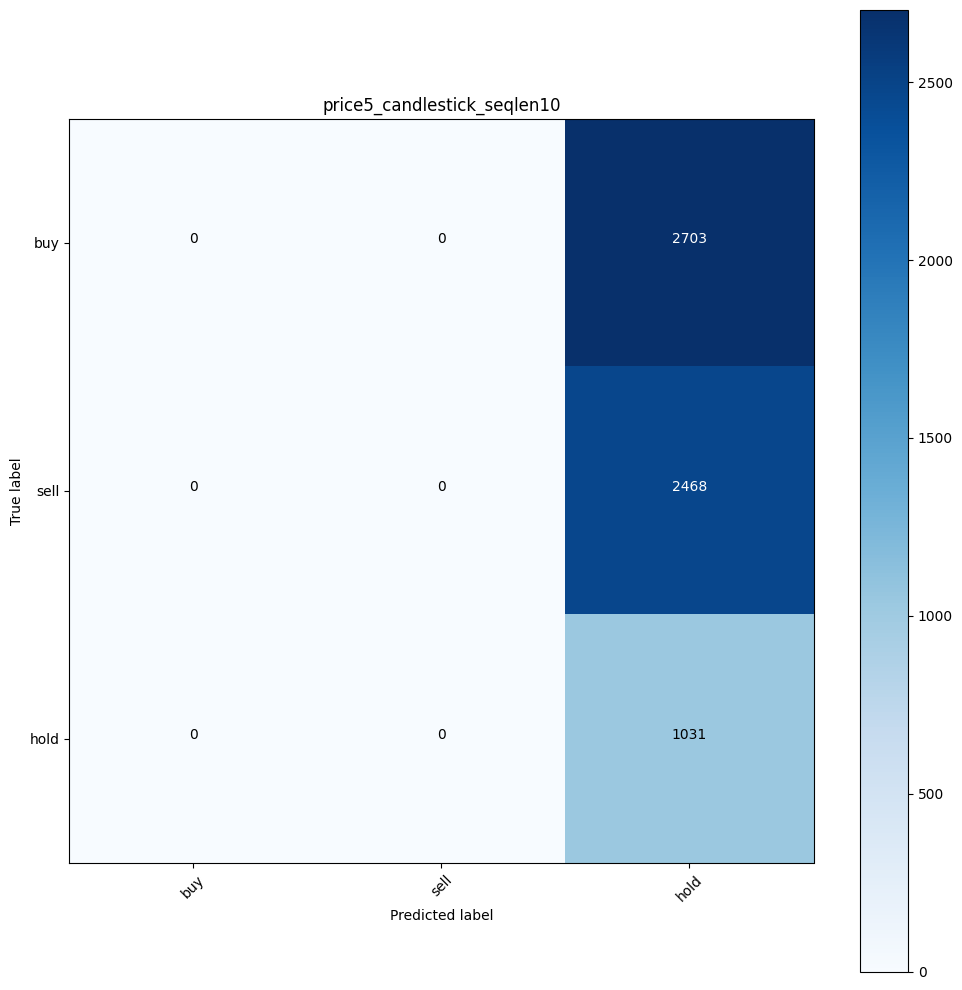

get result for seqlen 10 maxprice
price5_candlestick_seqlen10:
Mean Absolute Error: 0.16954509
Mean Absolute Percentage Error: 0.13019952
Mean Square Error: 0.05688828
Root Mean Square Error: 0.23851265

get result for seqlen 10 minprice
price5_candlestick_seqlen10:
Mean Absolute Error: 0.17870855
Mean Absolute Percentage Error: 0.13767115
Mean Square Error: 0.06257172
Root Mean Square Error: 0.25014339

total time spent 12.597973346710205


In [67]:
df_result, _ = model_evaluation(model, savepath_model, df_result, downstream_test_incl_price5, config.seqlen, modelname='price5_candlestick_seqlen'+str(seqlen))

df_result.to_csv(gd_result_folder+result_filename, index=False)

In [68]:
del downstream_train_incl_price5, downstream_valid_incl_price5, downstream_test_incl_price5
gc.collect()

1735867

### 4.3 features - price5(OHLC+avg) + TA + candlestick

In [69]:
downstream_train_incl_price5_ta = generateSeq4Downstream(df_downstream_train, ds_type="train", input_type="incl_price5_ta", seqlen=config.seqlen)
downstream_valid_incl_price5_ta = generateSeq4Downstream(df_downstream_valid, ds_type="valid", input_type="incl_price5_ta", seqlen=config.seqlen)
downstream_test_incl_price5_ta = generateSeq4Downstream(df_downstream_test, ds_type="test", input_type="incl_price5_ta", seqlen=config.seqlen)

#### 4.3.1 Build model

In [70]:
def create_ds_LSTM_price5_TA_candlestick(maxlen, seqlen):
    input_wtoken_candle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_candle')
    input_wtoken_pos = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_pos')
    input_wtoken_die = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_die')
    input_wtoken_cle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_cle')
    input_wtoken_ule = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_ule')
    input_wtoken_lle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_lle')
    input_segment = layers.Input((maxlen,), dtype=tf.int64, name='segment_ids')
    input_price5 = layers.Input((seqlen,5), dtype=tf.float32, name='prices5_scaled')
    input_TA = layers.Input((seqlen, 15), dtype=tf.float32, name='ta_scaled')

    wtoken_candle_embeddings = layers.Embedding(candlestick_vocab_size, config.EMBED_DIM, name='wtoken_candle_embedding')(input_wtoken_candle)
    wtoken_pos_embeddings = layers.Embedding(pos_vocab_size, config.EMBED_DIM, name='wtoken_pos_embedding')(input_wtoken_pos)
    wtoken_die_embeddings = layers.Embedding(direction_vocab_size, config.EMBED_DIM, name='direction_embedding')(input_wtoken_die)
    wtoken_cle_embeddings = layers.Embedding(candlepiece_vocab_size, config.EMBED_DIM, name='candlelen_embedding')(input_wtoken_cle)
    wtoken_ule_embeddings = layers.Embedding(candlepiece_vocab_size, config.EMBED_DIM, name='upperlen_embedding')(input_wtoken_ule)
    wtoken_lle_embeddings = layers.Embedding(candlepiece_vocab_size, config.EMBED_DIM, name='lowerlen_embedding')(input_wtoken_lle)
    segment_embeddings = layers.Embedding(segment_size, config.EMBED_DIM, name='segment_embedding')(input_segment)

    position_embeddings = layers.Embedding(
        input_dim=maxlen,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(maxlen, config.EMBED_DIM)],
        name="position_embedding")(tf.range(start=0, limit=maxlen, delta=1))

    embeddings = wtoken_candle_embeddings + wtoken_pos_embeddings + position_embeddings + segment_embeddings + \
                    wtoken_die_embeddings + wtoken_cle_embeddings + wtoken_ule_embeddings + wtoken_lle_embeddings

    embeddings_output = layers.LSTM(config.EMBED_DIM, activation="relu", return_sequences=False, name='embedding_LSTM')(embeddings)

    price5_output = layers.LSTM(config.EMBED_DIM, activation="relu", return_sequences=False, name='price5_scaled_LSTM')(input_price5)

    TA_output = layers.LSTM(config.EMBED_DIM, activation="relu", return_sequences=False, name='ta_scaled_LSTM')(input_TA)

    combined_output = layers.Concatenate()([embeddings_output, price5_output, TA_output])

    normalized_output = layers.LayerNormalization(epsilon=1e-6)(combined_output)
    regularization_layer = layers.LeakyReLU(alpha=0.1)(normalized_output)
    dropout_layer = layers.Dropout(0.1)(regularization_layer)

    x1 = layers.Dense(1024, activation="relu")(dropout_layer)
    x1 = layers.Dense(1024, activation="relu")(x1)
    x1 = layers.Dense(512, activation="relu")(x1)
    output_max_price = layers.Dense(1, activation="linear", name='max_price')(x1)

    x2 = layers.Dense(1024, activation="relu")(dropout_layer)
    x2 = layers.Dense(1024, activation="relu")(x2)
    x2 = layers.Dense(512, activation="relu")(x2)
    output_min_price = layers.Dense(1, activation="linear", name='min_price')(x2)

    x3 = layers.Dense(1024, activation="relu")(dropout_layer)
    x3 = layers.Dense(1024, activation="relu")(x3)
    x3 = layers.Dense(512, activation="relu")(x3)
    output_label_bhs = layers.Dense(3, activation="softmax", name='label_bhs')(x3)

    model = keras.Model(
            inputs=[input_wtoken_candle, input_wtoken_pos, input_wtoken_die, input_wtoken_cle, input_wtoken_ule, input_wtoken_lle, input_segment, input_price5, input_TA],
            outputs=[output_max_price, output_min_price, output_label_bhs])

    return model

#### 4.3.2 Train model

In [71]:
savepath_model = \
    gd_mdl_folder+'ds_price5_TA_candlestick_seqlen'+str(seqlen)+'_'+colab_filename.replace('.ipynb', '.h5')
savepath_model_weights = savepath_model.replace('.h5', '_weights.h5')
savepath_model_checkpoint = savepath_model_weights.replace('.h5', '_cp.h5')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(savepath_model_checkpoint, monitor="val_loss", verbose=0, mode="min",
                                                        save_best_only=True, save_weights_only=True, save_freq="epoch" )
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=config.patience, verbose=1, mode="min", restore_best_weights=True)

model = create_ds_LSTM_price5_TA_candlestick(config.maxlen, seqlen)
#model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss={
            "max_price": keras.losses.MeanSquaredError(),
            "min_price": keras.losses.MeanSquaredError(),
            "label_bhs": keras.losses.SparseCategoricalCrossentropy(),
        },
    metrics={
            "max_price": tf.keras.metrics.RootMeanSquaredError(),
            "min_price": tf.keras.metrics.RootMeanSquaredError(),
            "label_bhs": 'accuracy',
        }
    )
model.fit(
            x=downstream_train_incl_price5_ta[0], y=downstream_train_incl_price5_ta[1],
            epochs=config.EPOCH,
            validation_data=downstream_valid_incl_price5_ta,
            batch_size=config.BATCH_SIZE,
            callbacks=[checkpoint_cb, early_stop]
        )

model.save(savepath_model)
model.save_weights(savepath_model_weights)

Epoch 1/3
49/49 [==============================] - 26s 386ms/step - loss: 2.8538 - max_price_loss: 1.1722 - min_price_loss: 0.5722 - label_bhs_loss: 1.1094 - max_price_root_mean_squared_error: 1.0827 - min_price_root_mean_squared_error: 0.7564 - label_bhs_accuracy: 0.4005 - val_loss: 2.2555 - val_max_price_loss: 0.5881 - val_min_price_loss: 0.5340 - val_label_bhs_loss: 1.1334 - val_max_price_root_mean_squared_error: 0.7668 - val_min_price_root_mean_squared_error: 0.7308 - val_label_bhs_accuracy: 0.3038
Epoch 2/3
49/49 [==============================] - 15s 304ms/step - loss: 2.1523 - max_price_loss: 0.5327 - min_price_loss: 0.5394 - label_bhs_loss: 1.0802 - max_price_root_mean_squared_error: 0.7299 - min_price_root_mean_squared_error: 0.7344 - label_bhs_accuracy: 0.4286 - val_loss: 2.2314 - val_max_price_loss: 0.5881 - val_min_price_loss: 0.5218 - val_label_bhs_loss: 1.1215 - val_max_price_root_mean_squared_error: 0.7669 - val_min_price_root_mean_squared_error: 0.7223 - val_label_bhs_a

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 4.3.3 Test result

194/194 [==============================] - 4s 20ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.0000    0.0000    0.0000      2703
        hold     0.1662    1.0000    0.2851      1031
        sell     0.0000    0.0000    0.0000      2468

    accuracy                         0.1662      6202
   macro avg     0.0554    0.3333    0.0950      6202
weighted avg     0.0276    0.1662    0.0474      6202



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

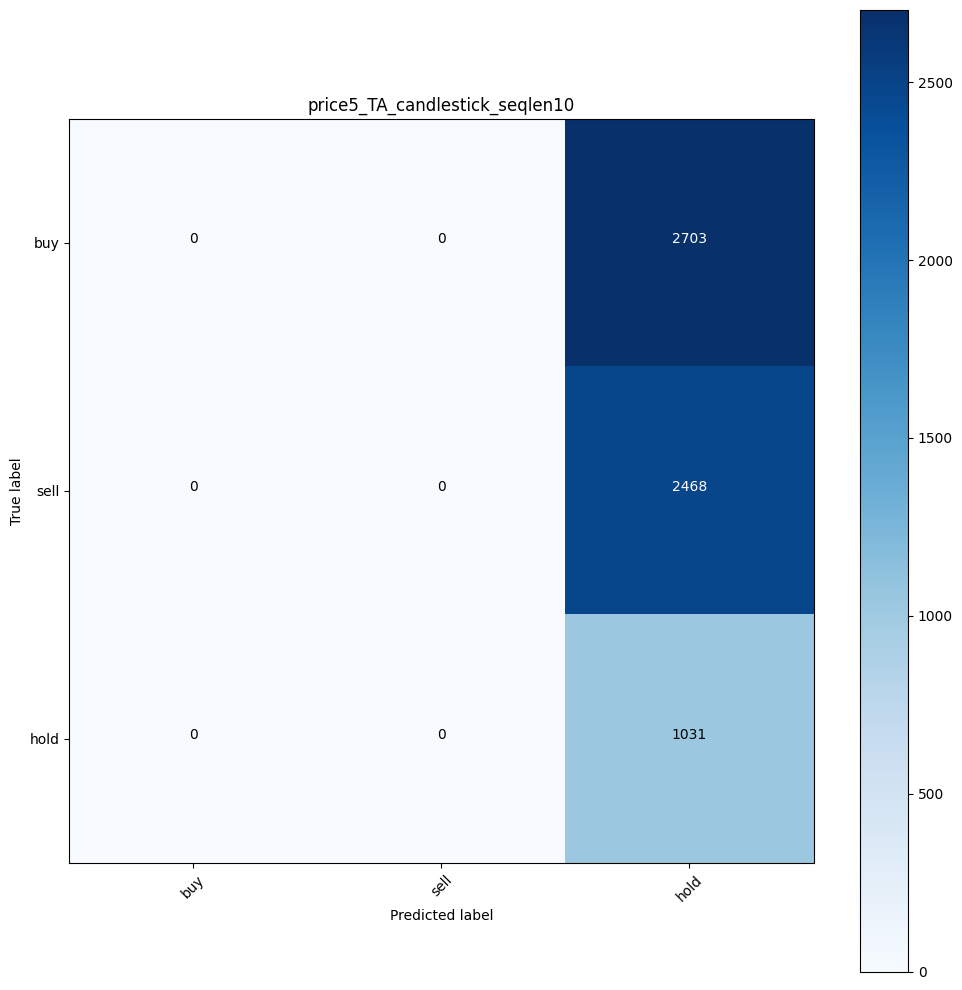

get result for seqlen 10 maxprice
price5_TA_candlestick_seqlen10:
Mean Absolute Error: 0.15879668
Mean Absolute Percentage Error: 0.12197704
Mean Square Error: 0.04918600
Root Mean Square Error: 0.22177918

get result for seqlen 10 minprice
price5_TA_candlestick_seqlen10:
Mean Absolute Error: 0.16438216
Mean Absolute Percentage Error: 0.12663227
Mean Square Error: 0.05665464
Root Mean Square Error: 0.23802235

total time spent 13.364916563034058


In [72]:
df_result, _ = model_evaluation(model, savepath_model, df_result, downstream_test_incl_price5_ta, config.seqlen, modelname='price5_TA_candlestick_seqlen'+str(seqlen))

df_result.to_csv(gd_result_folder+result_filename, index=False)

In [73]:
del downstream_train_incl_price5_ta, downstream_valid_incl_price5_ta, downstream_test_incl_price5_ta
gc.collect()

59201

### 4.4 features - price5(OHLC+avg) + TA

In [74]:
downstream_train_price5_ta = generateSeq4Downstream(df_downstream_train, ds_type="train", input_type="price5_ta", seqlen=config.seqlen)
downstream_valid_price5_ta = generateSeq4Downstream(df_downstream_valid, ds_type="valid", input_type="price5_ta", seqlen=config.seqlen)
downstream_test_price5_ta = generateSeq4Downstream(df_downstream_test, ds_type="test", input_type="price5_ta", seqlen=config.seqlen)

#### 4.4.1 Build model

In [75]:
def create_ds_LSTM_price5_TA(maxlen, seqlen):
    input_price5 = layers.Input((seqlen,5), dtype=tf.float32, name='prices5_scaled')
    input_TA = layers.Input((seqlen, 15), dtype=tf.float32, name='ta_scaled')

    price5_output = layers.LSTM(config.EMBED_DIM, activation="relu", return_sequences=False, name='price5_scaled_LSTM')(input_price5)

    TA_output = layers.LSTM(config.EMBED_DIM, activation="relu", return_sequences=False, name='ta_scaled_LSTM')(input_TA)

    combined_output = layers.Concatenate()([price5_output, TA_output])

    normalized_output = layers.LayerNormalization(epsilon=1e-6)(combined_output)
    regularization_layer = layers.LeakyReLU(alpha=0.1)(normalized_output)
    dropout_layer = layers.Dropout(0.1)(regularization_layer)

    x1 = layers.Dense(1024, activation="relu")(dropout_layer)
    x1 = layers.Dense(1024, activation="relu")(x1)
    x1 = layers.Dense(512, activation="relu")(x1)
    output_max_price = layers.Dense(1, activation="linear", name='max_price')(x1)

    x2 = layers.Dense(1024, activation="relu")(dropout_layer)
    x2 = layers.Dense(1024, activation="relu")(x2)
    x2 = layers.Dense(512, activation="relu")(x2)
    output_min_price = layers.Dense(1, activation="linear", name='min_price')(x2)

    x3 = layers.Dense(1024, activation="relu")(dropout_layer)
    x3 = layers.Dense(1024, activation="relu")(x3)
    x3 = layers.Dense(512, activation="relu")(x3)
    output_label_bhs = layers.Dense(3, activation="softmax", name='label_bhs')(x3)

    model = keras.Model(
            inputs=[input_price5, input_TA],
            outputs=[output_max_price, output_min_price, output_label_bhs])

    return model

#### 4.4.2 Train model

In [76]:
savepath_model = \
    gd_mdl_folder+'ds_price5_TA_seqlen'+str(seqlen)+'_'+colab_filename.replace('.ipynb', '.h5')
savepath_model_weights = savepath_model.replace('.h5', '_weights.h5')
savepath_model_checkpoint = savepath_model_weights.replace('.h5', '_cp.h5')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(savepath_model_checkpoint, monitor="val_loss", verbose=0, mode="min",
                                                        save_best_only=True, save_weights_only=True, save_freq="epoch" )
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=config.patience, verbose=1, mode="min", restore_best_weights=True)

model = create_ds_LSTM_price5_TA(config.maxlen, seqlen)
#model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss={
            "max_price": keras.losses.MeanSquaredError(),
            "min_price": keras.losses.MeanSquaredError(),
            "label_bhs": keras.losses.SparseCategoricalCrossentropy(),
        },
    metrics={
            "max_price": tf.keras.metrics.RootMeanSquaredError(),
            "min_price": tf.keras.metrics.RootMeanSquaredError(),
            "label_bhs": 'accuracy',
        }
    )
model.fit(
            x=downstream_train_price5_ta[0], y=downstream_train_price5_ta[1],
            epochs=config.EPOCH,
            validation_data=downstream_valid_price5_ta,
            batch_size=config.BATCH_SIZE,
            callbacks=[checkpoint_cb, early_stop]
        )

model.save(savepath_model)
model.save_weights(savepath_model_weights)

Epoch 1/3
49/49 [==============================] - 8s 46ms/step - loss: 2.2126 - max_price_loss: 0.5802 - min_price_loss: 0.5475 - label_bhs_loss: 1.0849 - max_price_root_mean_squared_error: 0.7617 - min_price_root_mean_squared_error: 0.7399 - label_bhs_accuracy: 0.4242 - val_loss: 2.2016 - val_max_price_loss: 0.5703 - val_min_price_loss: 0.5099 - val_label_bhs_loss: 1.1213 - val_max_price_root_mean_squared_error: 0.7552 - val_min_price_root_mean_squared_error: 0.7141 - val_label_bhs_accuracy: 0.3038
Epoch 2/3
49/49 [==============================] - 2s 34ms/step - loss: 2.0798 - max_price_loss: 0.4838 - min_price_loss: 0.5171 - label_bhs_loss: 1.0789 - max_price_root_mean_squared_error: 0.6955 - min_price_root_mean_squared_error: 0.7191 - label_bhs_accuracy: 0.4288 - val_loss: 2.1654 - val_max_price_loss: 0.5410 - val_min_price_loss: 0.5016 - val_label_bhs_loss: 1.1228 - val_max_price_root_mean_squared_error: 0.7355 - val_min_price_root_mean_squared_error: 0.7083 - val_label_bhs_accur

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 4.4.3 Test result

194/194 [==============================] - 1s 5ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.0000    0.0000    0.0000      2703
        hold     0.1670    0.9913    0.2858      1031
        sell     0.4125    0.0134    0.0259      2468

    accuracy                         0.1701      6202
   macro avg     0.1932    0.3349    0.1039      6202
weighted avg     0.1919    0.1701    0.0578      6202



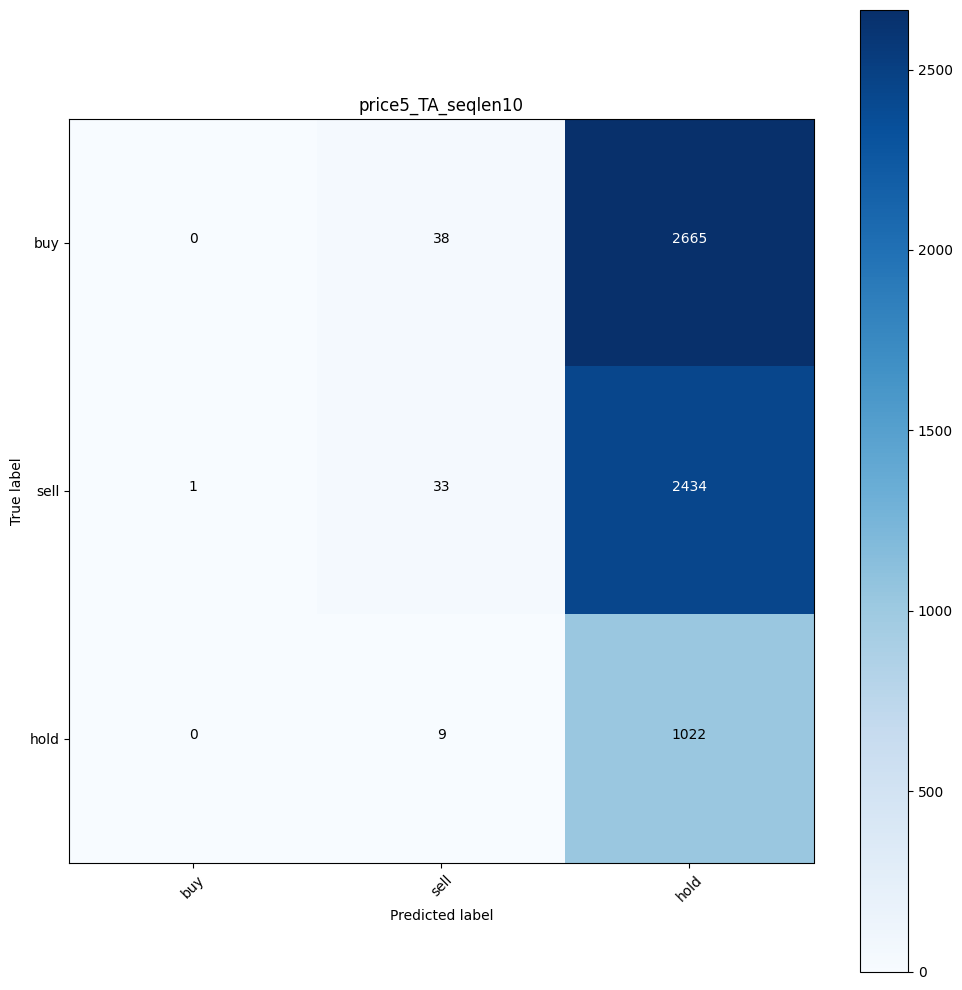

get result for seqlen 10 maxprice
price5_TA_seqlen10:
Mean Absolute Error: 0.14198258
Mean Absolute Percentage Error: 0.10909953
Mean Square Error: 0.03918838
Root Mean Square Error: 0.19796055

get result for seqlen 10 minprice
price5_TA_seqlen10:
Mean Absolute Error: 0.17001228
Mean Absolute Percentage Error: 0.13095996
Mean Square Error: 0.05634345
Root Mean Square Error: 0.23736776

total time spent 4.670258522033691


In [77]:
df_result, _ = model_evaluation(model, savepath_model, df_result, downstream_test_price5_ta, config.seqlen, modelname='price5_TA_seqlen'+str(seqlen))

df_result.to_csv(gd_result_folder+result_filename, index=False)

In [78]:
del downstream_train_price5_ta, downstream_valid_price5_ta, downstream_test_price5_ta
gc.collect()

23588

### 4.5 features - price5(OHLC+avg)

In [79]:
downstream_train_price5only = generateSeq4Downstream(df_downstream_train, ds_type="train", input_type="price5only", seqlen=config.seqlen)
downstream_valid_price5only = generateSeq4Downstream(df_downstream_valid, ds_type="valid", input_type="price5only", seqlen=config.seqlen)
downstream_test_price5only = generateSeq4Downstream(df_downstream_test, ds_type="test", input_type="price5only", seqlen=config.seqlen)

#### 4.5.1 Build model

In [80]:
def create_ds_LSTM_price5(maxlen, seqlen):
    input_price5 = layers.Input((seqlen,5), dtype=tf.float32, name='prices5_scaled')

    price5_output = layers.LSTM(config.EMBED_DIM, activation="relu", return_sequences=False, name='price5_scaled_LSTM')(input_price5)

    combined_output = price5_output

    normalized_output = layers.LayerNormalization(epsilon=1e-6)(combined_output)
    regularization_layer = layers.LeakyReLU(alpha=0.1)(normalized_output)
    dropout_layer = layers.Dropout(0.1)(regularization_layer)

    x1 = layers.Dense(1024, activation="relu")(dropout_layer)
    x1 = layers.Dense(1024, activation="relu")(x1)
    x1 = layers.Dense(512, activation="relu")(x1)
    output_max_price = layers.Dense(1, activation="linear", name='max_price')(x1)

    x2 = layers.Dense(1024, activation="relu")(dropout_layer)
    x2 = layers.Dense(1024, activation="relu")(x2)
    x2 = layers.Dense(512, activation="relu")(x2)
    output_min_price = layers.Dense(1, activation="linear", name='min_price')(x2)

    x3 = layers.Dense(1024, activation="relu")(dropout_layer)
    x3 = layers.Dense(1024, activation="relu")(x3)
    x3 = layers.Dense(512, activation="relu")(x3)
    output_label_bhs = layers.Dense(3, activation="softmax", name='label_bhs')(x3)

    model = keras.Model(
            inputs=[input_price5],
            outputs=[output_max_price, output_min_price, output_label_bhs])

    return model

#### 4.5.2 Train model

In [81]:
savepath_model = \
    gd_mdl_folder+'ds_price5_seqlen'+str(seqlen)+'_'+colab_filename.replace('.ipynb', '.h5')
savepath_model_weights = savepath_model.replace('.h5', '_weights.h5')
savepath_model_checkpoint = savepath_model_weights.replace('.h5', '_cp.h5')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(savepath_model_checkpoint, monitor="val_loss", verbose=0, mode="min",
                                                        save_best_only=True, save_weights_only=True, save_freq="epoch" )
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=config.patience, verbose=1, mode="min", restore_best_weights=True)

model = create_ds_LSTM_price5(config.maxlen, seqlen)
#model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss={
            "max_price": keras.losses.MeanSquaredError(),
            "min_price": keras.losses.MeanSquaredError(),
            "label_bhs": keras.losses.SparseCategoricalCrossentropy(),
        },
    metrics={
            "max_price": tf.keras.metrics.RootMeanSquaredError(),
            "min_price": tf.keras.metrics.RootMeanSquaredError(),
            "label_bhs": 'accuracy',
        }
    )
model.fit(
            x=downstream_train_price5only[0], y=downstream_train_price5only[1],
            epochs=config.EPOCH,
            validation_data=downstream_valid_price5only,
            batch_size=config.BATCH_SIZE,
            callbacks=[checkpoint_cb, early_stop]
        )

model.save(savepath_model)
model.save_weights(savepath_model_weights)

Epoch 1/3
49/49 [==============================] - 6s 30ms/step - loss: 2.4316 - max_price_loss: 0.8065 - min_price_loss: 0.5438 - label_bhs_loss: 1.0812 - max_price_root_mean_squared_error: 0.8981 - min_price_root_mean_squared_error: 0.7375 - label_bhs_accuracy: 0.4256 - val_loss: 2.2366 - val_max_price_loss: 0.5882 - val_min_price_loss: 0.5219 - val_label_bhs_loss: 1.1264 - val_max_price_root_mean_squared_error: 0.7670 - val_min_price_root_mean_squared_error: 0.7225 - val_label_bhs_accuracy: 0.3038
Epoch 2/3
49/49 [==============================] - 1s 20ms/step - loss: 2.1181 - max_price_loss: 0.5117 - min_price_loss: 0.5278 - label_bhs_loss: 1.0786 - max_price_root_mean_squared_error: 0.7153 - min_price_root_mean_squared_error: 0.7265 - label_bhs_accuracy: 0.4287 - val_loss: 2.1878 - val_max_price_loss: 0.5496 - val_min_price_loss: 0.5131 - val_label_bhs_loss: 1.1251 - val_max_price_root_mean_squared_error: 0.7413 - val_min_price_root_mean_squared_error: 0.7163 - val_label_bhs_accur

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 4.5.3 Test result

194/194 [==============================] - 1s 3ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.0000    0.0000    0.0000      2703
        hold     0.1662    1.0000    0.2851      1031
        sell     0.0000    0.0000    0.0000      2468

    accuracy                         0.1662      6202
   macro avg     0.0554    0.3333    0.0950      6202
weighted avg     0.0276    0.1662    0.0474      6202



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

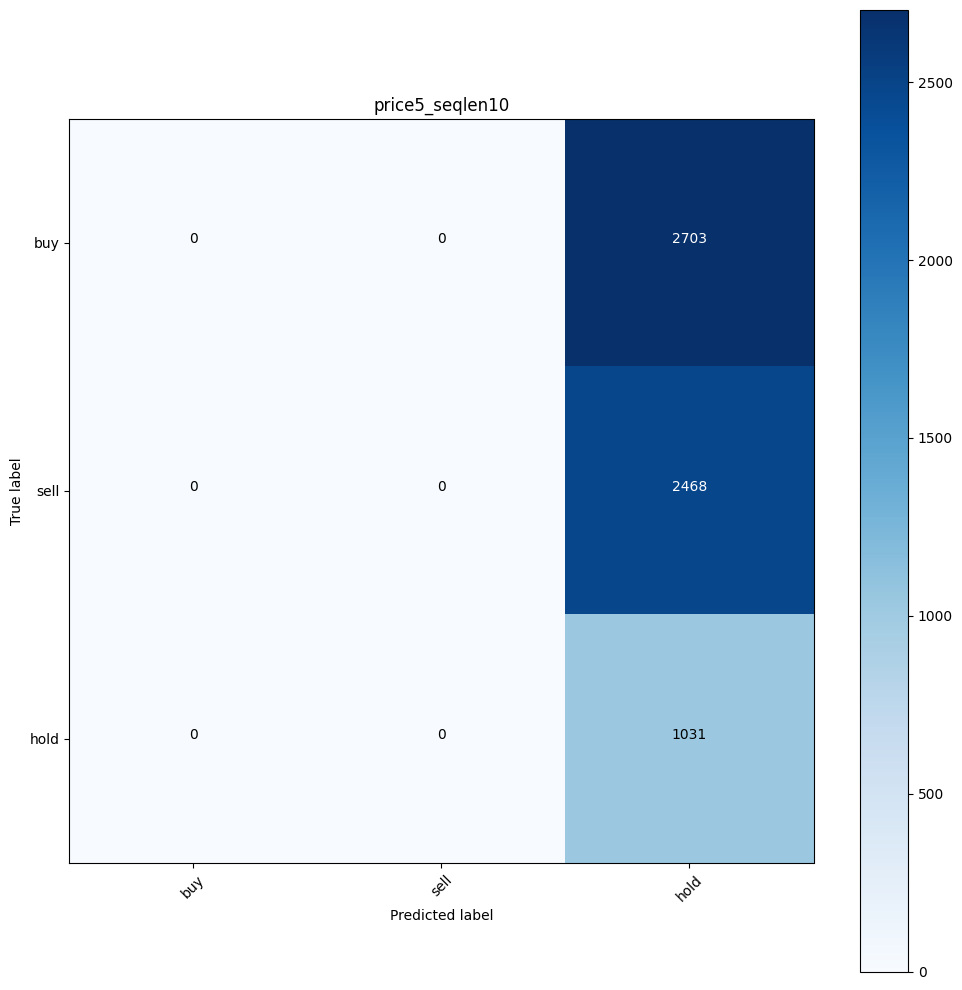

get result for seqlen 10 maxprice
price5_seqlen10:
Mean Absolute Error: 0.15022528
Mean Absolute Percentage Error: 0.11542414
Mean Square Error: 0.04294727
Root Mean Square Error: 0.20723724

get result for seqlen 10 minprice
price5_seqlen10:
Mean Absolute Error: 0.17187613
Mean Absolute Percentage Error: 0.13241602
Mean Square Error: 0.05840459
Root Mean Square Error: 0.24167041

total time spent 3.6724863052368164


In [82]:
df_result, _ = model_evaluation(model, savepath_model, df_result, downstream_test_price5only, config.seqlen, modelname='price5_seqlen'+str(seqlen))

df_result.to_csv(gd_result_folder+result_filename, index=False)

In [83]:
del downstream_train_price5only, downstream_valid_price5only, downstream_test_price5only
gc.collect()

18717

### 4.6 features - TA

In [84]:
downstream_train_taonly = generateSeq4Downstream(df_downstream_train, ds_type="train", input_type="taonly", seqlen=config.seqlen)
downstream_valid_taonly = generateSeq4Downstream(df_downstream_valid, ds_type="valid", input_type="taonly", seqlen=config.seqlen)
downstream_test_taonly = generateSeq4Downstream(df_downstream_test, ds_type="test", input_type="taonly", seqlen=config.seqlen)

#### 4.6.1 Build model

In [85]:
def create_ds_LSTM_TA(maxlen, seqlen):
    input_TA = layers.Input((seqlen, 15), dtype=tf.float32, name='ta_scaled')

    TA_output = layers.LSTM(config.EMBED_DIM, activation="relu", return_sequences=False, name='ta_scaled_LSTM')(input_TA)

    combined_output = TA_output

    normalized_output = layers.LayerNormalization(epsilon=1e-6)(combined_output)
    regularization_layer = layers.LeakyReLU(alpha=0.1)(normalized_output)
    dropout_layer = layers.Dropout(0.1)(regularization_layer)

    x1 = layers.Dense(1024, activation="relu")(dropout_layer)
    x1 = layers.Dense(1024, activation="relu")(x1)
    x1 = layers.Dense(512, activation="relu")(x1)
    output_max_price = layers.Dense(1, activation="linear", name='max_price')(x1)

    x2 = layers.Dense(1024, activation="relu")(dropout_layer)
    x2 = layers.Dense(1024, activation="relu")(x2)
    x2 = layers.Dense(512, activation="relu")(x2)
    output_min_price = layers.Dense(1, activation="linear", name='min_price')(x2)

    x3 = layers.Dense(1024, activation="relu")(dropout_layer)
    x3 = layers.Dense(1024, activation="relu")(x3)
    x3 = layers.Dense(512, activation="relu")(x3)
    output_label_bhs = layers.Dense(3, activation="softmax", name='label_bhs')(x3)

    model = keras.Model(
            inputs=[input_TA],
            outputs=[output_max_price, output_min_price, output_label_bhs])

    return model

#### 4.6.2 Train model

In [86]:
savepath_model = \
    gd_mdl_folder+'ds_TA_seqlen'+str(seqlen)+'_'+colab_filename.replace('.ipynb', '.h5')
savepath_model_weights = savepath_model.replace('.h5', '_weights.h5')
savepath_model_checkpoint = savepath_model_weights.replace('.h5', '_cp.h5')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(savepath_model_checkpoint, monitor="val_loss", verbose=0, mode="min",
                                                        save_best_only=True, save_weights_only=True, save_freq="epoch" )
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=config.patience, verbose=1, mode="min", restore_best_weights=True)

model = create_ds_LSTM_TA(config.maxlen, seqlen)
#model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss={
            "max_price": keras.losses.MeanSquaredError(),
            "min_price": keras.losses.MeanSquaredError(),
            "label_bhs": keras.losses.SparseCategoricalCrossentropy(),
        },
    metrics={
            "max_price": tf.keras.metrics.RootMeanSquaredError(),
            "min_price": tf.keras.metrics.RootMeanSquaredError(),
            "label_bhs": 'accuracy',
        }
    )
model.fit(
            x=downstream_train_taonly[0], y=downstream_train_taonly[1],
            epochs=config.EPOCH,
            validation_data=downstream_valid_taonly,
            batch_size=config.BATCH_SIZE,
            callbacks=[checkpoint_cb, early_stop]
        )

model.save(savepath_model)
model.save_weights(savepath_model_weights)

Epoch 1/3
49/49 [==============================] - 6s 30ms/step - loss: 2.8187 - max_price_loss: 1.1758 - min_price_loss: 0.5523 - label_bhs_loss: 1.0905 - max_price_root_mean_squared_error: 1.0844 - min_price_root_mean_squared_error: 0.7432 - label_bhs_accuracy: 0.4042 - val_loss: 2.2255 - val_max_price_loss: 0.5821 - val_min_price_loss: 0.5166 - val_label_bhs_loss: 1.1268 - val_max_price_root_mean_squared_error: 0.7630 - val_min_price_root_mean_squared_error: 0.7187 - val_label_bhs_accuracy: 0.3038
Epoch 2/3
49/49 [==============================] - 1s 20ms/step - loss: 2.1232 - max_price_loss: 0.5189 - min_price_loss: 0.5251 - label_bhs_loss: 1.0791 - max_price_root_mean_squared_error: 0.7203 - min_price_root_mean_squared_error: 0.7247 - label_bhs_accuracy: 0.4287 - val_loss: 2.2061 - val_max_price_loss: 0.5695 - val_min_price_loss: 0.5113 - val_label_bhs_loss: 1.1253 - val_max_price_root_mean_squared_error: 0.7547 - val_min_price_root_mean_squared_error: 0.7150 - val_label_bhs_accur

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 4.6.3 Test result

194/194 [==============================] - 1s 4ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.0000    0.0000    0.0000      2703
        hold     0.1662    1.0000    0.2851      1031
        sell     0.0000    0.0000    0.0000      2468

    accuracy                         0.1662      6202
   macro avg     0.0554    0.3333    0.0950      6202
weighted avg     0.0276    0.1662    0.0474      6202



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

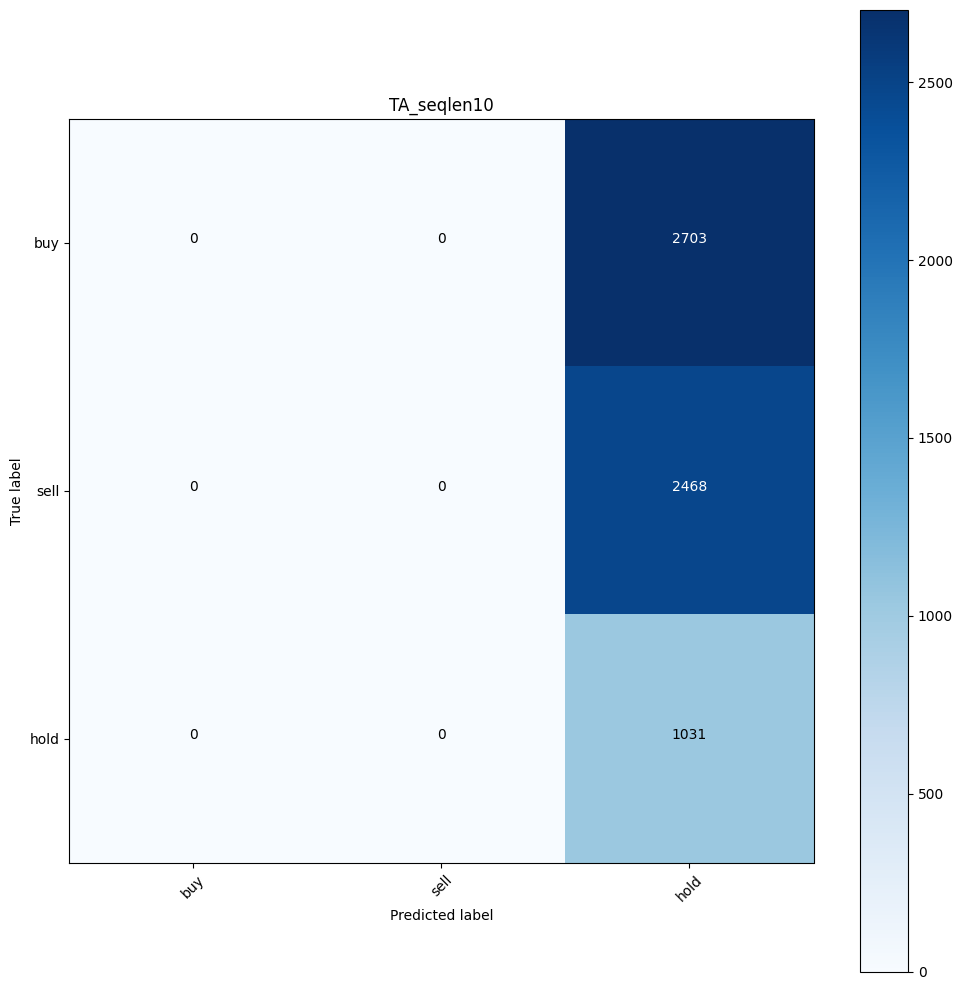

get result for seqlen 10 maxprice
TA_seqlen10:
Mean Absolute Error: 0.15245533
Mean Absolute Percentage Error: 0.11711056
Mean Square Error: 0.04488466
Root Mean Square Error: 0.21186001

get result for seqlen 10 minprice
TA_seqlen10:
Mean Absolute Error: 0.17192135
Mean Absolute Percentage Error: 0.13243273
Mean Square Error: 0.05916670
Root Mean Square Error: 0.24324207

total time spent 3.74311900138855


In [87]:
df_result, _ = model_evaluation(model, savepath_model, df_result, downstream_test_taonly, config.seqlen, modelname='TA_seqlen'+str(seqlen))

df_result.to_csv(gd_result_folder+result_filename, index=False)

In [88]:
del downstream_train_taonly, downstream_valid_taonly, downstream_test_taonly
gc.collect()

6951

### 4.7 features - candlestick

In [89]:
downstream_train_candleonly = generateSeq4Downstream(df_downstream_train, ds_type="train", input_type="candleonly", seqlen=config.seqlen)
downstream_valid_candleonly = generateSeq4Downstream(df_downstream_valid, ds_type="valid", input_type="candleonly", seqlen=config.seqlen)
downstream_test_candleonly = generateSeq4Downstream(df_downstream_test, ds_type="test", input_type="candleonly", seqlen=config.seqlen)

#### 4.7.1 build model

In [90]:
def create_ds_LSTM_candlestick(maxlen, seqlen):
    input_wtoken_candle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_candle')
    input_wtoken_pos = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_pos')
    input_wtoken_die = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_die')
    input_wtoken_cle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_cle')
    input_wtoken_ule = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_ule')
    input_wtoken_lle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_lle')
    input_segment = layers.Input((maxlen,), dtype=tf.int64, name='segment_ids')

    wtoken_candle_embeddings = layers.Embedding(candlestick_vocab_size, config.EMBED_DIM, name='wtoken_candle_embedding')(input_wtoken_candle)
    wtoken_pos_embeddings = layers.Embedding(pos_vocab_size, config.EMBED_DIM, name='wtoken_pos_embedding')(input_wtoken_pos)
    wtoken_die_embeddings = layers.Embedding(direction_vocab_size, config.EMBED_DIM, name='direction_embedding')(input_wtoken_die)
    wtoken_cle_embeddings = layers.Embedding(candlepiece_vocab_size, config.EMBED_DIM, name='candlelen_embedding')(input_wtoken_cle)
    wtoken_ule_embeddings = layers.Embedding(candlepiece_vocab_size, config.EMBED_DIM, name='upperlen_embedding')(input_wtoken_ule)
    wtoken_lle_embeddings = layers.Embedding(candlepiece_vocab_size, config.EMBED_DIM, name='lowerlen_embedding')(input_wtoken_lle)
    segment_embeddings = layers.Embedding(segment_size, config.EMBED_DIM, name='segment_embedding')(input_segment)

    position_embeddings = layers.Embedding(
        input_dim=maxlen,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(maxlen, config.EMBED_DIM)],
        name="position_embedding")(tf.range(start=0, limit=maxlen, delta=1))

    embeddings = wtoken_candle_embeddings + wtoken_pos_embeddings + position_embeddings + segment_embeddings + \
                    wtoken_die_embeddings + wtoken_cle_embeddings + wtoken_ule_embeddings + wtoken_lle_embeddings

    embeddings_output = layers.LSTM(config.EMBED_DIM, activation="relu", return_sequences=False, name='embedding_LSTM')(embeddings)

    combined_output = embeddings_output

    normalized_output = layers.LayerNormalization(epsilon=1e-6)(combined_output)
    regularization_layer = layers.LeakyReLU(alpha=0.1)(normalized_output)
    dropout_layer = layers.Dropout(0.1)(regularization_layer)

    x1 = layers.Dense(1024, activation="relu")(dropout_layer)
    x1 = layers.Dense(1024, activation="relu")(x1)
    x1 = layers.Dense(512, activation="relu")(x1)
    output_max_price = layers.Dense(1, activation="linear", name='max_price')(x1)

    x2 = layers.Dense(1024, activation="relu")(dropout_layer)
    x2 = layers.Dense(1024, activation="relu")(x2)
    x2 = layers.Dense(512, activation="relu")(x2)
    output_min_price = layers.Dense(1, activation="linear", name='min_price')(x2)

    x3 = layers.Dense(1024, activation="relu")(dropout_layer)
    x3 = layers.Dense(1024, activation="relu")(x3)
    x3 = layers.Dense(512, activation="relu")(x3)
    output_label_bhs = layers.Dense(3, activation="softmax", name='label_bhs')(x3)

    model = keras.Model(
            inputs=[input_wtoken_candle, input_wtoken_pos, input_wtoken_die, input_wtoken_cle, input_wtoken_ule, input_wtoken_lle, input_segment],
            outputs=[output_max_price, output_min_price, output_label_bhs])

    return model

#### 4.7.2 Train model

In [91]:
savepath_model = \
    gd_mdl_folder+'ds_candlestick_seqlen'+str(seqlen)+'_'+colab_filename.replace('.ipynb', '.h5')
savepath_model_weights = savepath_model.replace('.h5', '_weights.h5')
savepath_model_checkpoint = savepath_model_weights.replace('.h5', '_cp.h5')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(savepath_model_checkpoint, monitor="val_loss", verbose=0, mode="min",
                                                        save_best_only=True, save_weights_only=True, save_freq="epoch" )
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=config.patience, verbose=1, mode="min", restore_best_weights=True)

model = create_ds_LSTM_candlestick(config.maxlen, seqlen)
#model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss={
            "max_price": keras.losses.MeanSquaredError(),
            "min_price": keras.losses.MeanSquaredError(),
            "label_bhs": keras.losses.SparseCategoricalCrossentropy(),
        },
    metrics={
            "max_price": tf.keras.metrics.RootMeanSquaredError(),
            "min_price": tf.keras.metrics.RootMeanSquaredError(),
            "label_bhs": 'accuracy',
        }
    )
model.fit(
            x=downstream_train_candleonly[0], y=downstream_train_candleonly[1],
            epochs=config.EPOCH,
            validation_data=downstream_valid_candleonly,
            batch_size=config.BATCH_SIZE,
            callbacks=[checkpoint_cb, early_stop]
        )

model.save(savepath_model)
model.save_weights(savepath_model_weights)

Epoch 1/3
49/49 [==============================] - 22s 353ms/step - loss: 2.3197 - max_price_loss: 0.6323 - min_price_loss: 0.5812 - label_bhs_loss: 1.1062 - max_price_root_mean_squared_error: 0.7952 - min_price_root_mean_squared_error: 0.7624 - label_bhs_accuracy: 0.3807 - val_loss: 2.3342 - val_max_price_loss: 0.6205 - val_min_price_loss: 0.5794 - val_label_bhs_loss: 1.1342 - val_max_price_root_mean_squared_error: 0.7877 - val_min_price_root_mean_squared_error: 0.7612 - val_label_bhs_accuracy: 0.3038
Epoch 2/3
49/49 [==============================] - 12s 251ms/step - loss: 2.2018 - max_price_loss: 0.5424 - min_price_loss: 0.5796 - label_bhs_loss: 1.0797 - max_price_root_mean_squared_error: 0.7365 - min_price_root_mean_squared_error: 0.7613 - label_bhs_accuracy: 0.4287 - val_loss: 2.3277 - val_max_price_loss: 0.6180 - val_min_price_loss: 0.5810 - val_label_bhs_loss: 1.1287 - val_max_price_root_mean_squared_error: 0.7861 - val_min_price_root_mean_squared_error: 0.7622 - val_label_bhs_a

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 4.7.3 Test result

194/194 [==============================] - 3s 18ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.0000    0.0000    0.0000      2703
        hold     0.1662    1.0000    0.2851      1031
        sell     0.0000    0.0000    0.0000      2468

    accuracy                         0.1662      6202
   macro avg     0.0554    0.3333    0.0950      6202
weighted avg     0.0276    0.1662    0.0474      6202



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

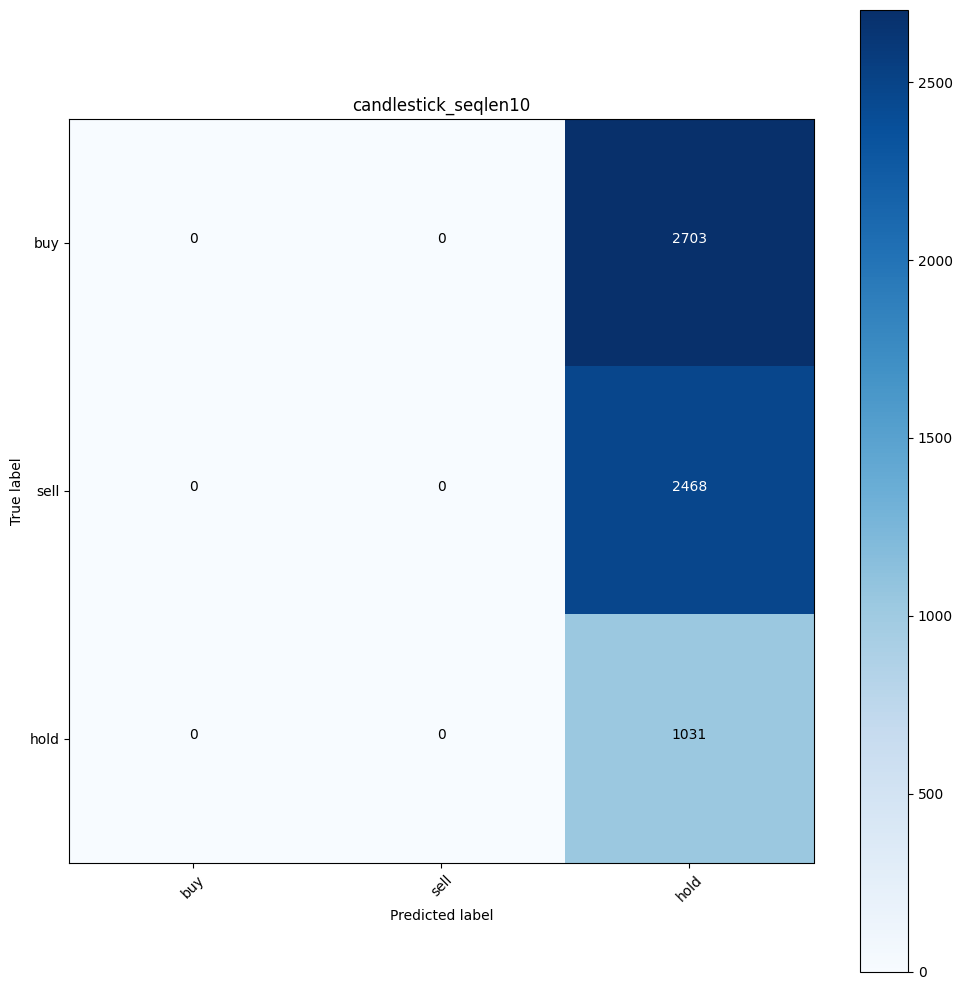

get result for seqlen 10 maxprice
candlestick_seqlen10:
Mean Absolute Error: 0.17144255
Mean Absolute Percentage Error: 0.13160400
Mean Square Error: 0.05917832
Root Mean Square Error: 0.24326595

get result for seqlen 10 minprice
candlestick_seqlen10:
Mean Absolute Error: 0.19716521
Mean Absolute Percentage Error: 0.15185727
Mean Square Error: 0.07458177
Root Mean Square Error: 0.27309663

total time spent 11.711718082427979


In [92]:
df_result, _ = model_evaluation(model, savepath_model, df_result, downstream_test_candleonly, config.seqlen, modelname='candlestick_seqlen'+str(seqlen))

df_result.to_csv(gd_result_folder+result_filename, index=False)

In [93]:
del downstream_train_candleonly, downstream_valid_candleonly, downstream_test_candleonly
gc.collect()

17080